In [336]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [337]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [338]:
# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

In [339]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

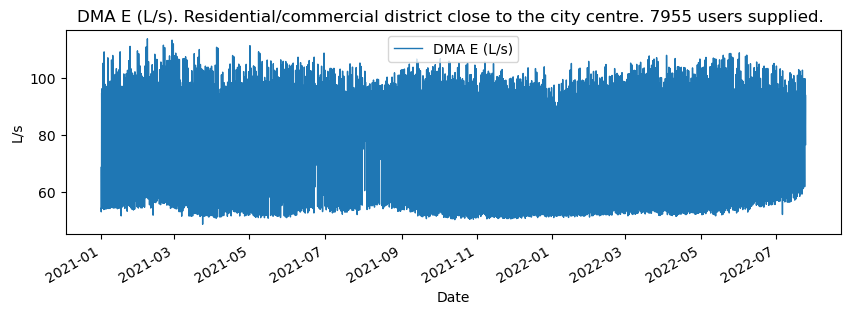

In [340]:
# select dma for analysis
dma = "DMA E (L/s)"
for i in range (len(dma_list)):
    if dma_list[i] == dma:
        j = i

# plot dma water demand time series
fig, ax = plt.subplots()
inflow_data.plot(y=dma,ax = ax,figsize=(10,3), linewidth=1)
plt.title(dma + ". " + dma_descripton[j] +". "+ str(users_supplied[j]) + " users supplied. ")
plt.xlabel("Date")
plt.ylabel("L/s")
plt.show()

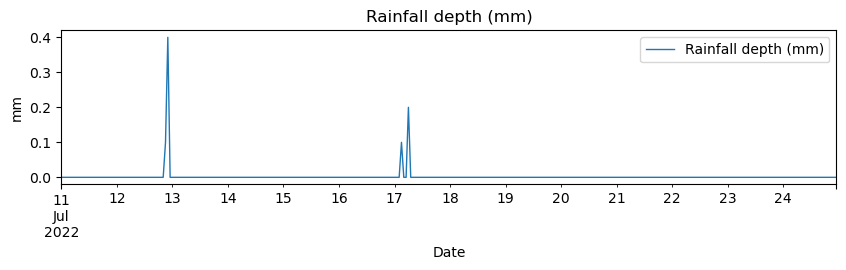

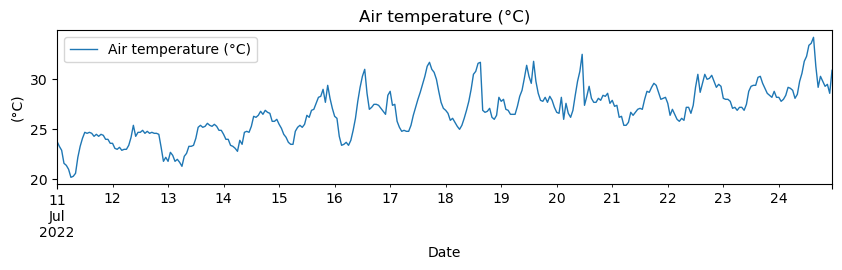

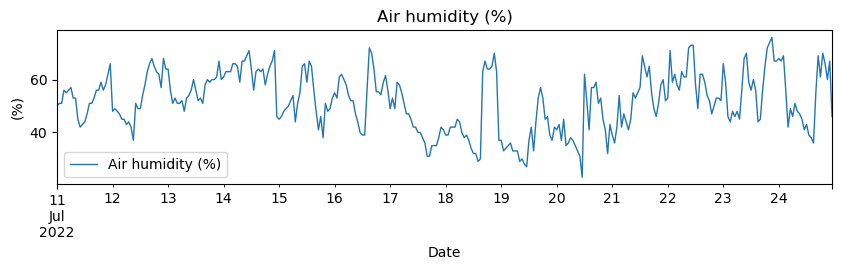

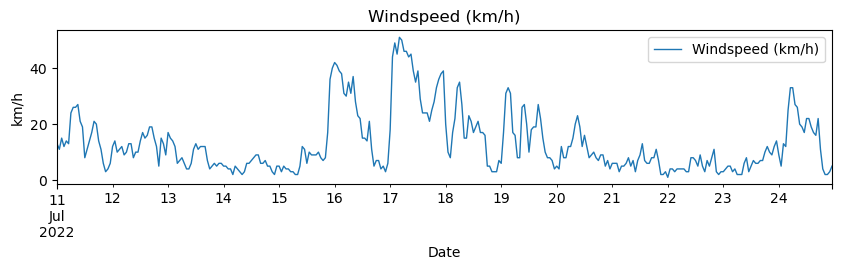

In [341]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-07-11'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

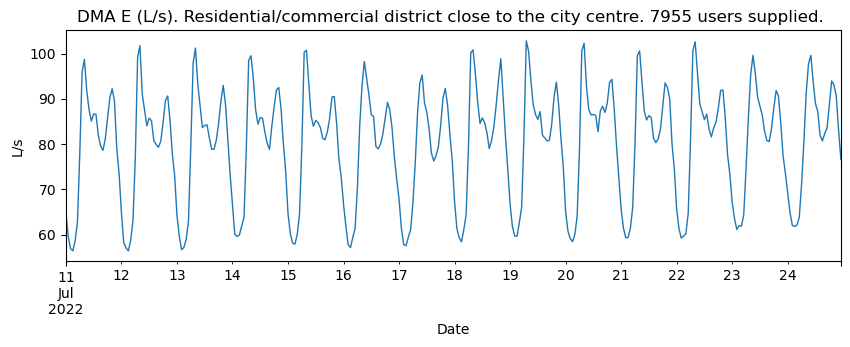

In [342]:
# select dma for analysis
dma = "DMA E (L/s)"
    
# copy data from dataframe in a new time series dataframe
tseries_df = inflow_data[dma][start:end].copy()


# plot dma water demand time series
fig, ax = plt.subplots()
tseries_df.plot(y=dma,ax = ax,figsize=(10,3), linewidth=1)
plt.title(dma + ". " + dma_descripton[j] +". "+ str(users_supplied[j]) + " users supplied. ")
plt.xlabel("Date")
plt.ylabel("L/s")
plt.show()

In [343]:
# stationarity test
# Null Hypothesis: The series has a unit root.
# Alternate Hypothesis: The series has no unit root.
result = adfuller(tseries_df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if (result[1] <= 0.05):
    print('series is stationary')
else:
    print('series is not stationary')

ADF Statistic: -10.538428
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572
series is stationary


In [344]:
# The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
# Null Hypothesis: The process is trend stationary.
# Alternate Hypothesis: The series has a unit root (series is not stationary).
result = kpss(tseries_df,regression='c',nlags='auto',store=False)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))
if (result[1] >= 0.05):
    print('series is stationary')
else:
    print('series is not stationary')

KPSS Statistic: 0.115075
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
series is stationary


results after applying 0 differencings


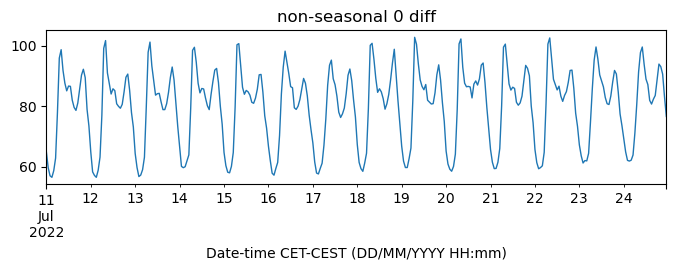

ADF Statistic: -10.538428
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572
series is stationary
KPSS Statistic: 0.115075
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
series is stationary


In [345]:
# check number of differencing needed
flag = True
d = 0
# zero differncing to start
non_seasonal_diff = tseries_df.copy()
max_iter = 10
while flag:

    # augmented dicker-fuller stationarity test
    result1 = adfuller(non_seasonal_diff.dropna())

    # Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.

    result2 = kpss(non_seasonal_diff.dropna(),regression='c',nlags='auto',store=False)

    if d == max_iter:
        print('maximum number of iterations reached')

        print('results after applying '+str(d)+' differencings')

        # plot non-seasonal first differencing
        fig, ax = plt.subplots()
        non_seasonal_diff.dropna().plot(y=dma,ax = ax,figsize=(8,2), linewidth=1)
        plt.title("non-seasonal "+str(d)+" diff")
        plt.show()

        print('ADF Statistic: %f' % result1[0])
        print('p-value: %f' % result1[1])
        print('Critical Values:')
        for key, value in result1[4].items():
            print('\t%s: %.3f' % (key, value))
        if (result1[1] <= 0.05):
            print('series is stationary')
        else:
            print('series is not stationary')

        print('KPSS Statistic: %f' % result2[0])
        print('p-value: %f' % result2[1])
        print('Critical Values:')
        for key, value in result2[3].items():
            print('\t%s: %.3f' % (key, value))
        if (result2[1] <= 0.05):
            print('series is stationary')
        else:
            print('series is not stationary')

        flag = False


    if (result1[1] <= 0.05  and result2[1] >= 0.05):

        print('results after applying '+str(d)+' differencings')

        # plot non-seasonal first differencing
        fig, ax = plt.subplots()
        non_seasonal_diff.dropna().plot(y=dma,ax = ax,figsize=(8,2), linewidth=1)
        plt.title("non-seasonal "+str(d)+" diff")
        plt.show()

        print('ADF Statistic: %f' % result1[0])
        print('p-value: %f' % result1[1])
        print('Critical Values:')
        for key, value in result1[4].items():
            print('\t%s: %.3f' % (key, value))
        if (result1[1] <= 0.05):
            print('series is stationary')
        else:
            print('series is not stationary')

        print('KPSS Statistic: %f' % result2[0])
        print('p-value: %f' % result2[1])
        print('Critical Values:')
        for key, value in result2[3].items():
            print('\t%s: %.3f' % (key, value))
        if (result2[1] >= 0.05):
            print('series is stationary')
        else:
            print('series is not stationary')

        flag = False

    d = d + 1
    
    non_seasonal_diff = non_seasonal_diff.diff()

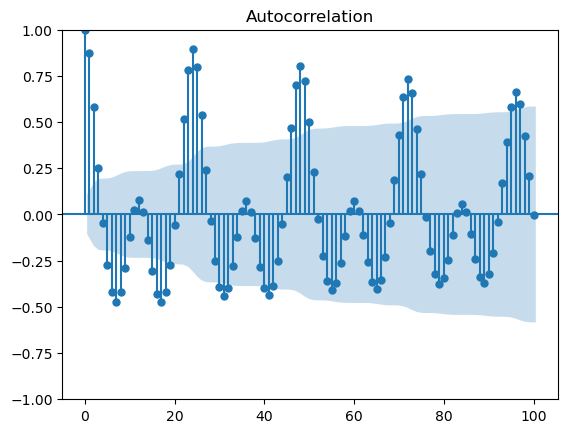

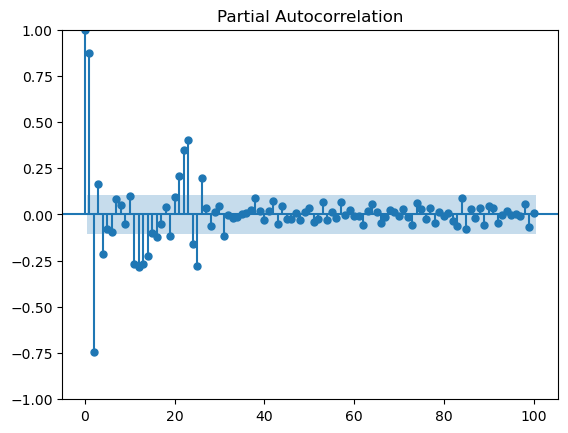

In [346]:
plot_acf(tseries_df, lags=100)
plt.show()

plot_pacf(tseries_df, lags=100, method="ywm")
plt.show()

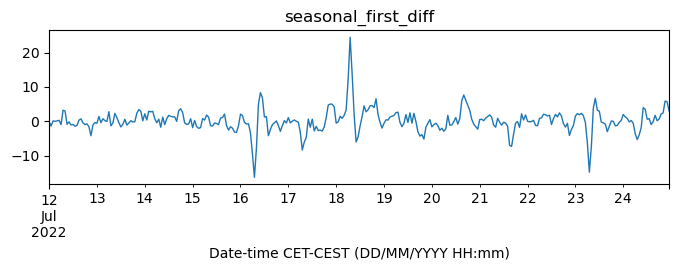

In [347]:
# check data removing seasonal components
seasonal_first_diff =tseries_df-tseries_df.shift(24)

# plot seasonal first differencing
fig, ax = plt.subplots()
seasonal_first_diff.dropna().plot(y=dma,ax = ax,figsize=(8,2), linewidth=1)
plt.title("seasonal_first_diff")
plt.show()

In [348]:
# stationarity test
result = adfuller(seasonal_first_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))
if (result1[1] <= 0.05):
    print('series is stationary')
else:
    print('series is not stationary')

ADF Statistic: -4.570773
p-value: 0.000146
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
series is stationary


In [349]:
# The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
# Null Hypothesis: The process is trend stationary.
# Alternate Hypothesis: The series has a unit root (series is not stationary).
result = kpss(seasonal_first_diff.dropna(),regression='c',nlags='auto',store=False)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))
if (result[1] >= 0.05):
    print('series is stationary')
else:
    print('series is not stationary')

KPSS Statistic: 0.067091
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
series is stationary


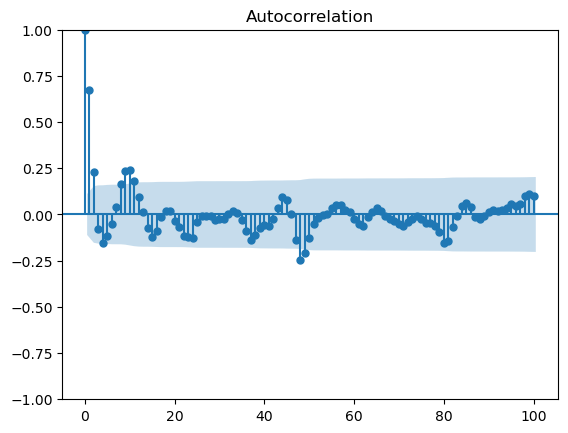

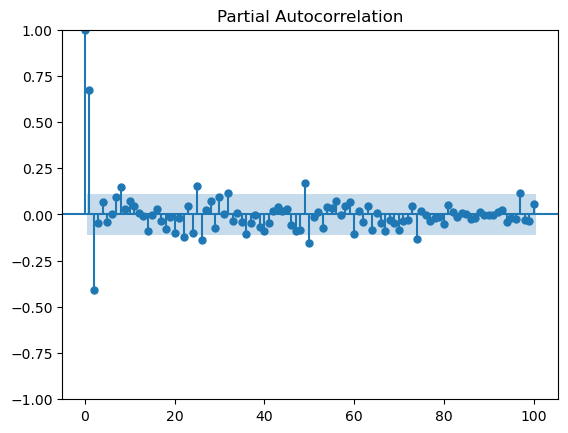

In [350]:
plot_acf(seasonal_first_diff.dropna(), lags=100)
plt.show()

plot_pacf(seasonal_first_diff.dropna(), lags=100, method="ywm")
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21486D+00    |proj g|=  7.93750D-01


 This problem is unconstrained.



At iterate    5    f=  1.87881D+00    |proj g|=  8.31111D-01

At iterate   10    f=  1.77368D+00    |proj g|=  1.13459D-01

At iterate   15    f=  1.76206D+00    |proj g|=  7.89374D-02

At iterate   20    f=  1.75896D+00    |proj g|=  2.44964D-02

At iterate   25    f=  1.75687D+00    |proj g|=  1.40198D-02

At iterate   30    f=  1.75588D+00    |proj g|=  3.53458D-02

At iterate   35    f=  1.75513D+00    |proj g|=  4.14116D-02

At iterate   40    f=  1.75465D+00    |proj g|=  3.18506D-02

At iterate   45    f=  1.75412D+00    |proj g|=  8.64521D-03

At iterate   50    f=  1.75372D+00    |proj g|=  2.93087D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

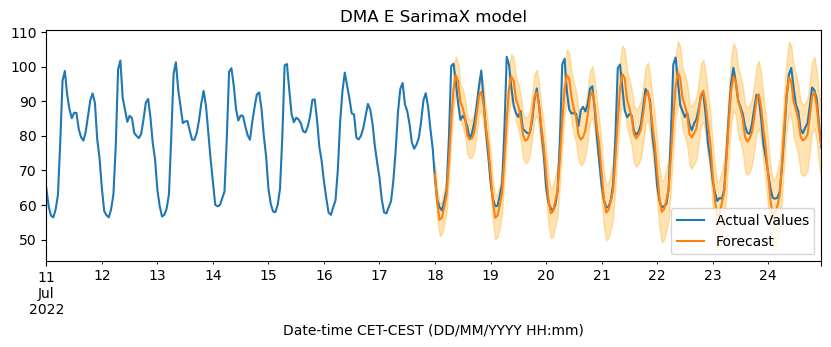

Performance indicators
DMA E SarimaX 1-Week
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.41            16.31             3.07           22.79 



In [351]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# demand time series
y = tseries_df
y_train, y_test = temporal_train_test_split(y, test_size = 168)

# exogenous variables time series
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# implement sarimaX model    
# the statsmodel package applies the difference already if needed.

model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
model_fit = model.fit()
print(model_fit.summary())

y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


fig, ax = plt.subplots(figsize = (10,3))
tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
y_pred.plot(y='mean',ax = ax)
ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

print('Performance indicators')
df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 1-Week',return_df=1)
results_df = pd.concat([results_df, df])

In [352]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA E SarimaX 1-Week,3.407,16.306,3.073,22.786


In [353]:
print(f"{results_df['Total'].sum() :.2f}")

22.79


In [354]:
# order=(4,0,3), seasonal_order=(0,1,1,24)
# to beat 3.407	16.306	3.073	22.786

In [355]:
print(f"{results_df.drop('DMA E SarimaX 1-Week')['Total'].sum() :.2f}")

0.00
